In [8]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import sys # 到其他資料夾

from importlib import reload # 自訂 function 可重新 reload
sys.path.append('/home/hchuang/Documents/Project/SSSD_CP/src')
from utils import util_inference_result
reload(util_inference_result)
from utils.util_inference_result import *

sys.path.append('/home/hchuang/Documents/Project/SSSD_CP/src/datasets_script/NYISO')
from utils.data_utils import *



# Functions

In [9]:
def CR_barchart_compare(original_values, adjusted_values2, 
                        figure_title = "Comparing 95% PI Coverage Rate: SSSD vs. Calibration",
                        label_1 = 'SSSD', label_2 = 'Calibration',
                        color_1 = 'tab:orange', color_2 = 'tab:blue'):
    """
    original_values: array, shape = (24,)
    adjusted_values2: array, shape = (24,)
    """
    X_axis = np.arange(original_values.shape[0]) 

    plt.figure(figsize=(20, 10)) 
    plt.rcParams['font.size'] = 24 # 設置繪圖時的字體大小
    plt.bar(X_axis - 0.2, original_values, 0.4, label = label_1, color = color_1) 
    plt.bar(X_axis + 0.2, adjusted_values2, 0.4, label = label_2, color = color_2) 

    # for i in X_axis:
        # plt.text(X_axis[i] - 0.2, original_values[i] + 0.02, str(round(original_values[i],2)), ha='center', va='bottom')
        # plt.text(X_axis[i] + 0.2, adjusted_values2[i] + 0.03, str(round(adjusted_values2[i],2)), ha='center', va='bottom')

    plt.axhline(y=0.95, color='r', linestyle='--', label='0.95')
    plt.axhline(y=1, color='black', linestyle='--', label='0.95')

    plt.ylim(0, 1.1)
    plt.xlabel("Hours") 
    plt.ylabel("") 
    plt.title(figure_title) 
    # plt.legend(loc = 'upper right', bbox_to_anchor=(1, 0.5)) 
    plt.legend(loc=(1.001, 0.79))
    plt.show() 

def err_boxplot(error_data, 
                figure_title = 'Boxplot of the absolute error'):
    """
    input:
        error_data is an array, shape: (# of obs, channel = 1, # of length)
    output: boxplot with  # of boxes = # of length, # of points of each boxes = # of obs
    """

    data_to_plot = np.squeeze(abs_err_I2) # reduce the channel dimension
    box_data = data_to_plot.T.tolist()
    # box_data is a list containing lists. 
    # The number of elements in the 1st level list represents the number of boxes.
    # The number  of elements in the 2nd level list represent the number of points of one box

    plt.figure(figsize=(10, 6))
    plt.boxplot(box_data) 
    plt.xlabel("Hours")
    plt.ylabel("Values")
    plt.title("Boxplot of the absolute error of the I2 dataset")
    plt.grid(True)
    plt.ylim((0,2))
    plt.show()

def prediction_linechart(obs, y, y_predict):
    """
    input: 
        one_obs: specify a number from the size of data (ie specify which series should plot)
        y: data values, an array, shape = (obs, length = 192)
        y_predict: prediciton, an array, shape = (obs, length = 24)
    """
    date = generate_date_from_seq(obs)
    
    x = range(0,y.shape[1])
    x_predict = range(y.shape[1]-y_predict.shape[1], y.shape[1])
    
    y_single = y[obs,:]
    y_predict_single = y_predict[obs,:]

    plt.figure(figsize=(16, 4)) 
    plt.plot(x, y_single, color = 'tab:gray', label = "Data")
    plt.plot(x_predict, y_predict_single, color = 'tab:blue', label = "Prediction")
    plt.title("" + date)
    # plt.xticks(rotation=45) 
    plt.ylim(-2.5, 2.5) 
    plt.legend(loc = "upper left")
    plt.show()

def PI_linechart(obs,y, L, U, figure_title = "Prediction interval", PI_label = "PI", PI_color = 'tab:blue'):
    """
    input: 
        one_obs: specify a number from the size of data (ie specify which series should plot)
        y: data values, an array, shape = (obs,  length = 192)
        L: lower bound of PI, an array, shape = (obs, length = 24)
        U: upper bound of PI, an array, shape = (obs, length = 24)
    """    
    date = generate_date_from_seq(obs)
    
    x = range(0,y.shape[1])
    x_predict = range(y.shape[1]-L.shape[1], y.shape[1])

    y_single = y[obs,:]
    lower = L[obs,:]
    upper = U[obs,:]

    plt.figure(figsize=(16, 4)) 
    plt.rcParams['font.size'] = 20 # 設置繪圖時的字體大小

    plt.plot(x, y_single, color = 'tab:gray', label = "Data")
    plt.title(figure_title +' ('+date+')')

    # plt.xticks(rotation=45) 
    plt.fill_between(x_predict, lower, upper, color=PI_color, alpha=0.4, label = PI_label)
    plt.ylim(-2.5, 2.5) 
    plt.legend(loc = "upper left")
    plt.show()    
def indicator_function(condition, shape):
    # Perform element-wise comparison and return 1 if condition is met, 0 otherwise
    return np.where(condition, 1, 0)
def Interval_Score(l,u,z,alpha):
    return (u-l)+2/alpha*(l-z)*indicator_function(z<l,z.shape)+2/alpha*(z-u)*indicator_function(z>u,z.shape)    

# Read data

In [10]:
main_folder_path = "/home/hchuang/Documents/Project/SSSD_CP/src/"

DATASET = 'dataset_4' # dataset_4 or dataset 6
if DATASET == 'dataset_4': # (test data = 73)
    
    result_folder_path = "results/NYISO_4/NYISO_4_NYC_split/T200_beta00.0001_betaT0.02/"
    I2_foldername = "imputaiton_multiple_20k_I2_part"
    test_foldername = "imputaiton_multiple_20k_test/"

    I2_dataset_folder_path = 'datasets/NYISO/dataset_4/zone_split/'
    I2_dataset_filename = 'I2_N.Y.C._train.npy'
    test_dataset_folder_path = 'datasets/NYISO/dataset_4/zone/'
    test_dataset_filename = 'N.Y.C._test.npy'
else: # (test data = 350)
    
    result_folder_path = "results/NYISO_4/NYISO_4_NYC_split/T200_beta00.0001_betaT0.02/"
    I2_foldername = "imputaiton_multiple_20k_I2_part"
    test_foldername = 'imputaiton_multiple_20k_test_dataset6'

    I2_dataset_folder_path = 'datasets/NYISO/dataset_6/zone_split/'
    I2_dataset_filename = 'I2_N.Y.C._train.npy'
    test_dataset_folder_path = 'datasets/NYISO/dataset_6/zone/'
    test_dataset_filename = 'N.Y.C._test.npy'


# I2 data in original scael
file_path = os.path.join(main_folder_path + I2_dataset_folder_path, I2_dataset_filename)
true_data_I2_all_o = np.squeeze(np.swapaxes(np.load(file_path), axis1=1, axis2=2))
true_data_I2_cond_o = true_data_I2_all_o[:,0:168]
true_data_I2_target_o = true_data_I2_all_o[:,-24:]
print(f"true_data_I2_all_o, shape: {true_data_I2_all_o.shape}")
print(f"true_data_I2_cond_o, shape: {true_data_I2_cond_o.shape}")
print(f"true_data_I2_target_o, shape: {true_data_I2_target_o.shape}")

# I2 data in normalized scale
m = np.mean(true_data_I2_cond_o, axis=1).reshape(1, true_data_I2_cond_o.shape[0], 1)
s = np.std(true_data_I2_cond_o, axis=1).reshape(1, true_data_I2_cond_o.shape[0], 1)
true_data_I2_all =  np.squeeze((true_data_I2_all_o-m)/s)
true_data_I2_cond = np.squeeze((true_data_I2_cond_o-m)/s)
true_data_I2_target = np.squeeze((true_data_I2_target_o-m)/s)
print(f"true_data_I2_all, shape: {true_data_I2_all.shape}")
print(f"true_data_I2_cond, shape: {true_data_I2_cond.shape}")
print(f"true_data_I2_target, shape: {true_data_I2_target.shape}")


# I2 prediction data in normalized scael
mul_pred_data_I2 = np.squeeze(np.vstack([read_multiple_imputations(main_folder_path + result_folder_path + I2_foldername + str(i) +'/', 24) for i in range(3)]))
median_pred_data_I2 = np.median(mul_pred_data_I2, axis = 0)
print(f"mul_pred_data_I2, shape: {mul_pred_data_I2.shape}")
print(f"median_pred_data_I2, shape: {median_pred_data_I2.shape}")


# pred I2 data back to original scale
mul_pred_data_I2_o = mul_pred_data_I2*s + m
median_pred_data_I2_o = np.squeeze(np.median(mul_pred_data_I2_o, axis = 0))
print(f"mul_pred_data_I2_o, shape: {mul_pred_data_I2_o.shape}")
print(f"median_pred_data_I2_o, shape: {median_pred_data_I2_o.shape}")

# test data in original scale
file_path = os.path.join(main_folder_path + test_dataset_folder_path, test_dataset_filename)
true_data_test_all_o = np.squeeze(np.swapaxes(np.load(file_path), axis1=1, axis2=2))
true_data_test_cond_o = true_data_test_all_o[:,0:168]
true_data_test_target_o = true_data_test_all_o[:,-24:]

print(f"true_data_test_all_o, shape: {true_data_test_all_o.shape}")
print(f"true_data_test_cond_o, shape: {true_data_test_cond_o.shape}")
print(f"true_data_test_target_o, shape: {true_data_test_target_o.shape}")

# test data in normalized scale
m = np.mean(true_data_test_cond_o, axis=1).reshape(1, true_data_test_cond_o.shape[0], 1)
s = np.std(true_data_test_cond_o, axis=1).reshape(1, true_data_test_cond_o.shape[0], 1)
true_data_test_all =  np.squeeze((true_data_test_all_o-m)/s)
true_data_test_cond =  np.squeeze((true_data_test_cond_o-m)/s)
true_data_test_target =  np.squeeze((true_data_test_target_o-m)/s)
print(f"true_data_test_all, shape: {true_data_test_all.shape}")
print(f"true_data_test_cond, shape: {true_data_test_cond.shape}")
print(f"true_data_test_target, shape: {true_data_test_target.shape}")

# pred test dataset in normalized scale
mul_pred_data_test = np.squeeze(read_multiple_imputations(main_folder_path + result_folder_path + test_foldername, 24))
median_pred_data_test = np.median(mul_pred_data_test, axis = 0)
print(f"mul_pred_data_test, shape: {mul_pred_data_test.shape}")
print(f"median_pred_data_test, shape: {median_pred_data_test.shape}")

# pred test data back to original scale
mul_pred_data_test_o = mul_pred_data_test*s + m
median_pred_data_test_o = np.median(mul_pred_data_test_o, axis = 0)
print(f"mul_pred_data_test_o, shape: {mul_pred_data_test_o.shape}")
print(f"median_pred_data_test_o, shape: {median_pred_data_test_o.shape}")



true_data_I2_all_o, shape: (2061, 192)
true_data_I2_cond_o, shape: (2061, 168)
true_data_I2_target_o, shape: (2061, 24)
true_data_I2_all, shape: (2061, 192)
true_data_I2_cond, shape: (2061, 168)
true_data_I2_target, shape: (2061, 24)
mul_pred_data_I2, shape: (50, 2061, 24)
median_pred_data_I2, shape: (2061, 24)
mul_pred_data_I2_o, shape: (50, 2061, 24)
median_pred_data_I2_o, shape: (2061, 24)
true_data_test_all_o, shape: (73, 192)
true_data_test_cond_o, shape: (73, 168)
true_data_test_target_o, shape: (73, 24)
true_data_test_all, shape: (73, 192)
true_data_test_cond, shape: (73, 168)
true_data_test_target, shape: (73, 24)
mul_pred_data_test, shape: (50, 73, 24)
median_pred_data_test, shape: (73, 24)
mul_pred_data_test_o, shape: (50, 73, 24)
median_pred_data_test_o, shape: (73, 24)


## select 10/20-12/31 as calibration set

In [11]:
# 0-read file
df_all_time = pd.read_pickle('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/df_all_time.pkl')
# 1-the day of the year
date_range = pd.date_range(start='2005-01-31', end='2016-10-19')
days = date_range.to_series().dt.dayofyear # 創建一個 Series，包含每個日期是一年當中第幾天
train_all_days = days[7:]
print(train_all_days.shape)


# 2-training data (在切割training and test data時會drop有nan的series，所以需要知道其 index)
df = df_all_time
train_start = '2005-01-31 00:00:00'
train_end = '2016-10-19 23:00:00'
test_start = '2016-10-13 00:00:00'
test_end = '2016-12-31 23:00:00'
zone_number = 1
days_window = 8
zone_name = 'N.Y.C.'

if zone_name == 'ALL':
    df_train = df[(df['Date']>=train_start) 
                & (df['Date']<=train_end)] 
    df_test  = df[(df['Date']>=test_start) 
                & (df['Date']<=test_end)]
else:
    df_train = df[(df['Zone']==zone_name) 
                & (df['Date']>=train_start) 
                & (df['Date']<=train_end)] 
    df_test  = df[(df['Zone']==zone_name) 
                & (df['Date']>=test_start)
                & (df['Date']<=test_end)]
    
np_train, day_of_week_train = pd_to_numpy(df_train, zone_number, days_window) # np_train.shape = 4273
# remove rows (reduce obs.) which contain nan,  (obs., channel, length)
load_array_train = np_train[~np.isnan(np_train).any(axis=(1,2))] 
# exchange channel and length (obs., 1, length) -> (obs., length, 1) 
load_array_train = np.einsum('ijk->ikj',load_array_train)


# 3-根據train沒有因為na被drop的index選取days
train_days = train_all_days[~np.isnan(np_train).any(axis=(1,2))] 
print(train_days.shape)


# 4-根據I1和I2 index切分 dyas
data_npy = load_array_train
np.random.seed(42)

random_indices = np.random.choice(data_npy.shape[0], data_npy.shape[0]//2, replace=False)
remaining_indices = np.setdiff1d(np.arange(data_npy.shape[0]), random_indices)

sample_I1 = data_npy[random_indices]
sample_I2 = data_npy[remaining_indices]

train_days_I1 = train_days.iloc[random_indices]
train_days_I2 = train_days.iloc[remaining_indices]
print(np.sum(train_days_I1>294))
print(np.sum(train_days_I2>294))

(4273,)
(4121,)
364
411


In [12]:
# I2_winter_index = train_days_I2>0 # all I2
# I2_winter_index = train_days_I2>=294 # >= 10/20

I2_winter_index = train_days_I2>=287 # >= 10/20

# CPI

## Data

In [13]:

pred_I2 = mul_pred_data_I2[:,I2_winter_index,:]
true_I2 = true_data_I2_target[I2_winter_index,:]
median_pred_I2 = np.median(pred_I2, axis = 0)

pred_test = mul_pred_data_test
true_test = true_data_test_target
true_test_all = true_data_test_target
median_pred_test = median_pred_data_test

## 1: CPI_B

### Method

In [14]:
pred_data = mul_pred_data_I2
true_data = true_data_I2_target

# conformity score
L, U = pred_interval(pred_data, beta = 0.05)
E_star = compute_E_star(L, U, true_data, alpha = 0.05)
print(E_star)

# calibration data
# L, U = pred_interval(pred_data, beta = 0.05)
# L_star, U_star = adjust_PI(L, U, E_star)
# I2_CR_original = coverage_rate(L, U, true_data)
# I2_CR_adjust = coverage_rate(L_star, U_star, true_data)
# CR_barchart_compare(I2_CR_original[0], I2_CR_adjust[0])

# test data
L, U = pred_interval(mul_pred_data_test, beta = 0.05)
L_star, U_star = adjust_PI(L, U, E_star)

[0.05384741 0.09172458 0.11642264 0.13371347 0.1524984  0.18523765
 0.26519732 0.33959873 0.38149973 0.44327589 0.49378809 0.54925132
 0.60272056 0.6370673  0.65506702 0.69598607 0.70043326 0.70143394
 0.6712415  0.6453997  0.63114439 0.63184822 0.62629913 0.58751508]


### Results

#### Coverage rate

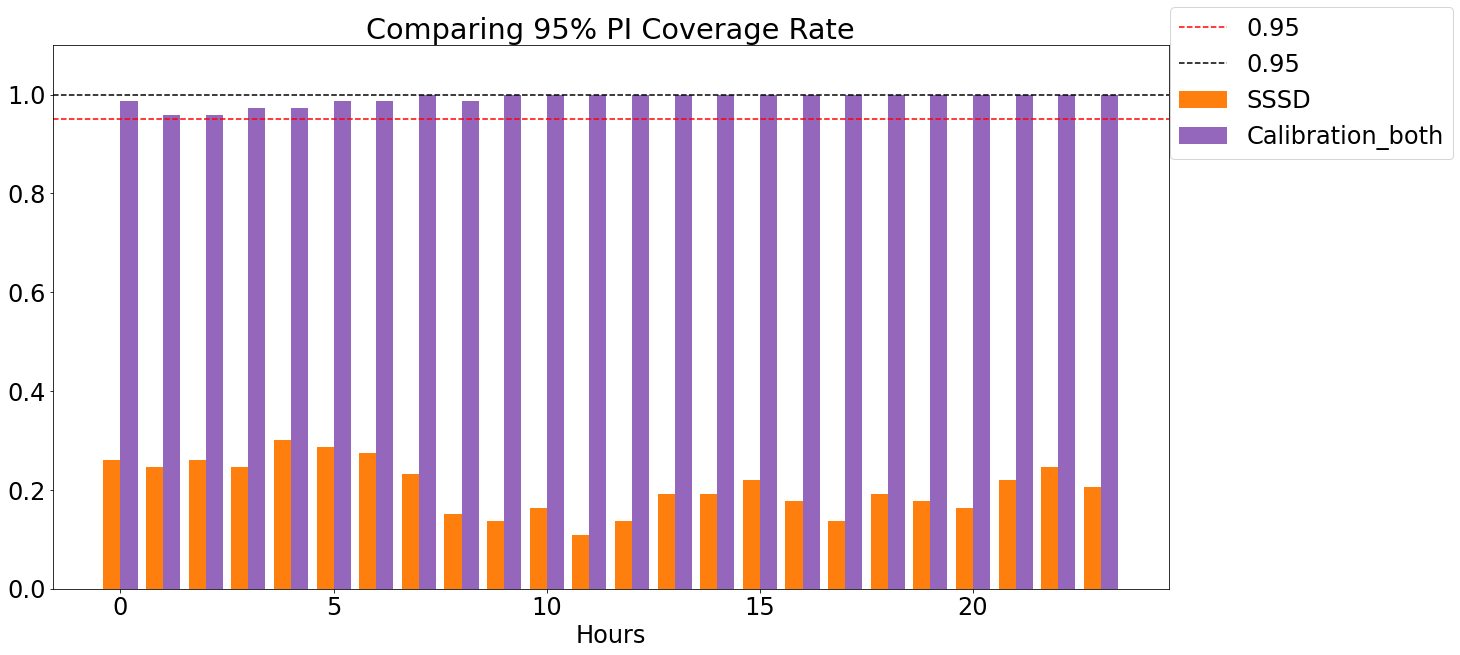

In [15]:
test_CR_original = coverage_rate(L, U, true_data_test_target)
test_CR_adjust_1 = coverage_rate(L_star, U_star, true_data_test_target)

CR_barchart_compare(test_CR_original, test_CR_adjust_1, 
                    figure_title = "Comparing 95% PI Coverage Rate",
                    label_1 = 'SSSD', label_2 = 'Calibration_both',
                    color_1 = 'tab:orange', color_2 = 'tab:purple')

#### PI visualization

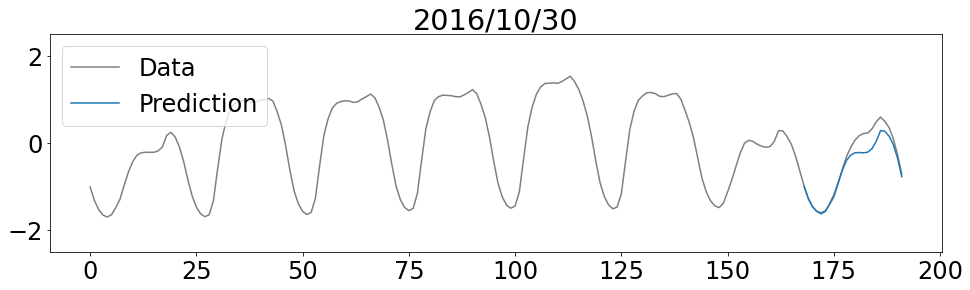

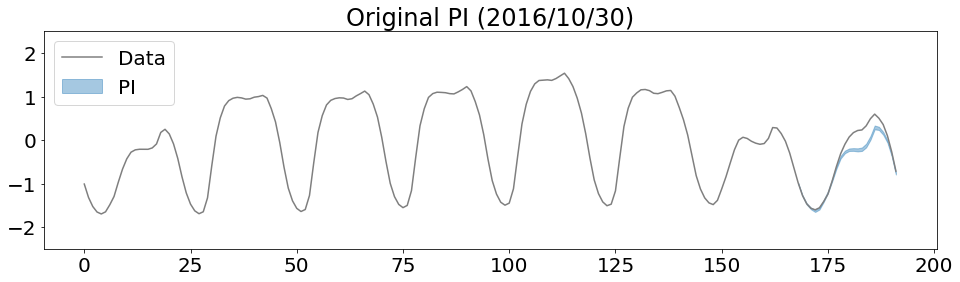

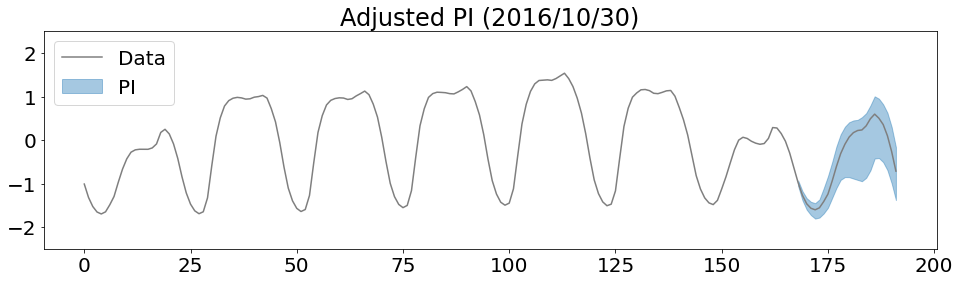

In [16]:
pred_mean_I2 = np.mean(mul_pred_data_I2, axis = 0)
pred_mean_test = np.mean(mul_pred_data_test,axis=0)


one_obs = 10
prediction_linechart(one_obs, true_data_test_all, pred_mean_test)
PI_linechart(one_obs, true_data_test_all, L, U, figure_title = "Original PI")
PI_linechart(one_obs, true_data_test_all, L_star, U_star, figure_title = "Adjusted PI")


## 2: CPI_E

### Method

In [17]:
L, U = pred_interval(pred_I2, beta = 0.05)

# conformity score
E_star_L, E_star_U = compute_E_star_separate(L, U, true_I2, alpha = 0.025)
print(f'E_star_L: {E_star_L}, E_star_U: {E_star_U}')

# caibration data
# L, U = pred_interval(pred_I2, beta = 0.05)
# L_star, U_star = adjust_PI_separate(L, U, E_star_L, E_star_U)
# I2_CR_original = coverage_rate(L, U, true_I2)
# I2_CR_adjust = coverage_rate(L_star, U_star, true_I2)
# CR_barchart_compare(I2_CR_original[0], I2_CR_adjust[0])

# test data
L, U = pred_interval(pred_test, beta = 0.05)
L_star, U_star = adjust_PI_separate(L, U, E_star_L, E_star_U)


E_star_L: [0.06642669 0.10612033 0.12564876 0.12335272 0.12892654 0.15861228
 0.22000494 0.27097167 0.26381043 0.28502919 0.26186289 0.27557436
 0.29665967 0.34497527 0.39273506 0.41555623 0.43479781 0.3959307
 0.35720607 0.34266038 0.35862984 0.32868126 0.24430238 0.19838876], E_star_U: [0.01758214 0.02695909 0.02954491 0.04542109 0.05786469 0.0852579
 0.16224446 0.24266899 0.28241734 0.32630571 0.37274054 0.41722428
 0.47495507 0.47014293 0.49423692 0.49142105 0.49916423 0.48403294
 0.42461373 0.41306524 0.38776712 0.321394   0.31716715 0.30219851]


### Result


#### Coverage rate

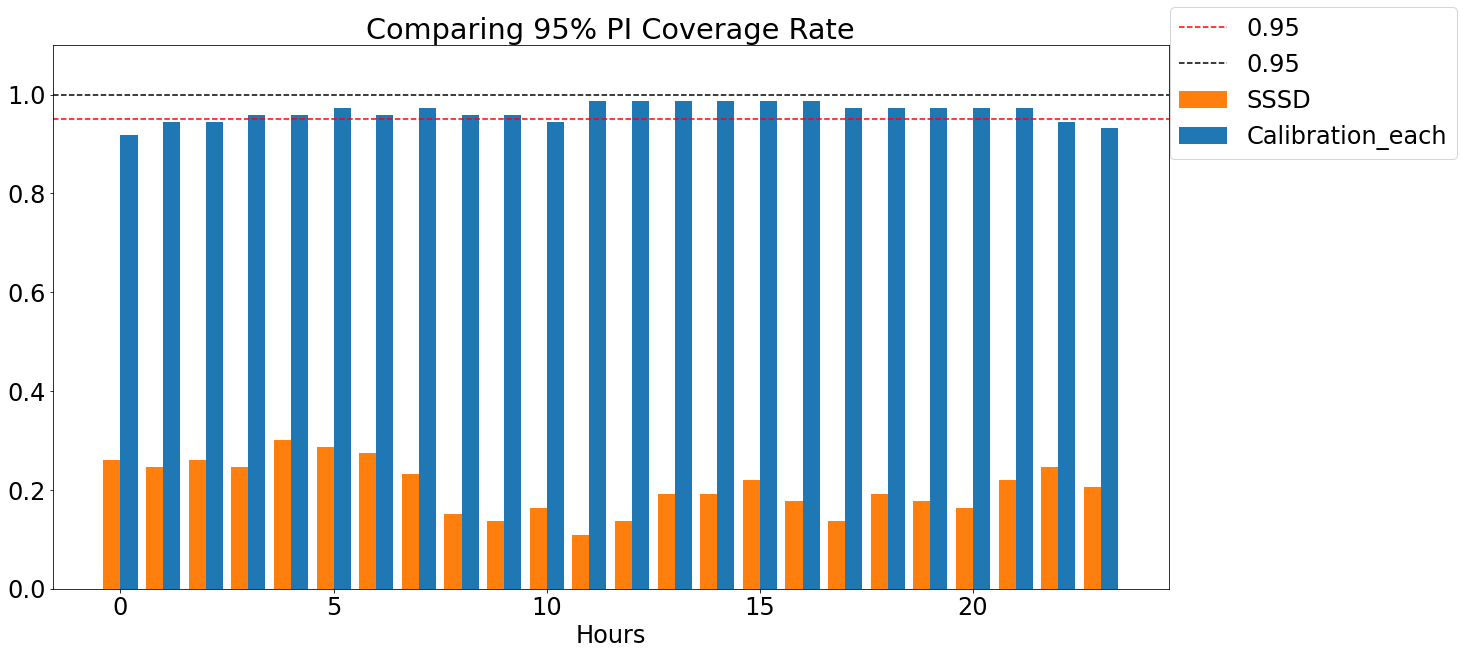

In [18]:


test_CR_original = coverage_rate(L, U, true_test)
test_CR_adjust_2 = coverage_rate(L_star, U_star, true_test)

CR_barchart_compare(test_CR_original, test_CR_adjust_2, 
                    figure_title = "Comparing 95% PI Coverage Rate",
                    label_1 = 'SSSD', label_2 = 'Calibration_each',
                    color_1 = 'tab:orange', color_2 = 'tab:blue')

#### Plot PI

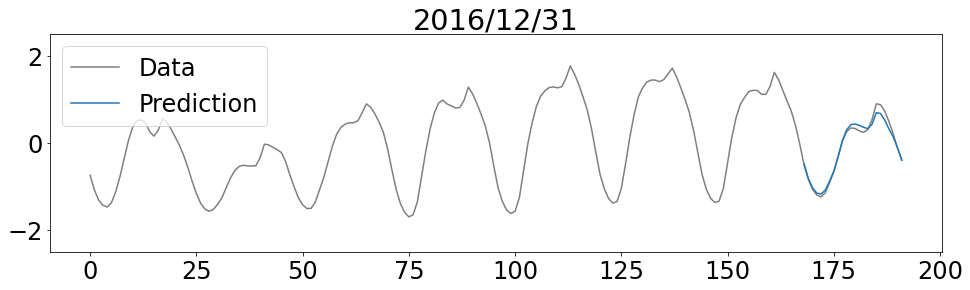

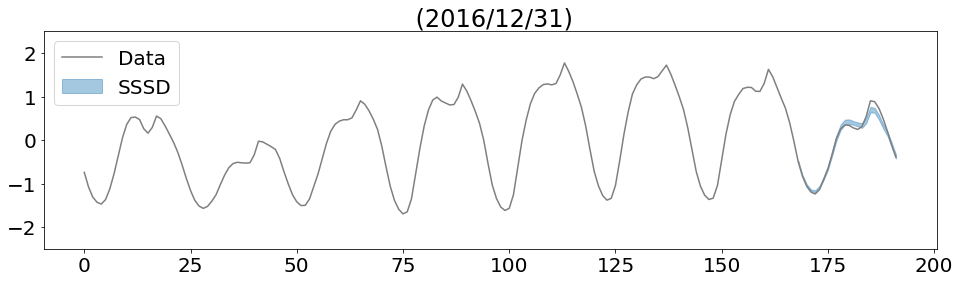

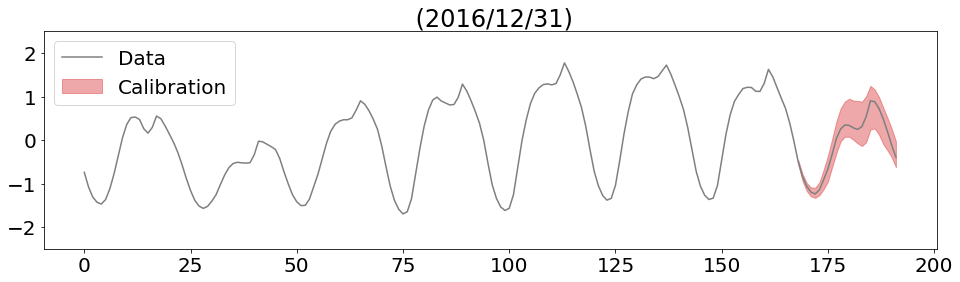

In [19]:
one_obs = 72 # 0, 13, 30, 72
prediction_linechart(one_obs, true_data_test_all, median_pred_data_test)
PI_linechart(one_obs, true_data_test_all, L, U, figure_title = "", PI_label = "SSSD", PI_color = 'tab:blue')
PI_linechart(one_obs, true_data_test_all, L_star, U_star, figure_title = "", PI_label = "Calibration", PI_color = 'tab:red')


#### Interval Score

In [20]:
IS = Interval_Score(L_star,U_star,true_test,0.05)
np.round(np.mean(IS, axis=0),2)

array([0.16, 0.23, 0.29, 0.33, 0.35, 0.38, 0.52, 0.64, 0.71, 0.79, 0.82,
       0.84, 0.9 , 0.91, 1.  , 1.03, 1.07, 1.13, 1.13, 1.11, 1.04, 0.95,
       0.87, 0.82])

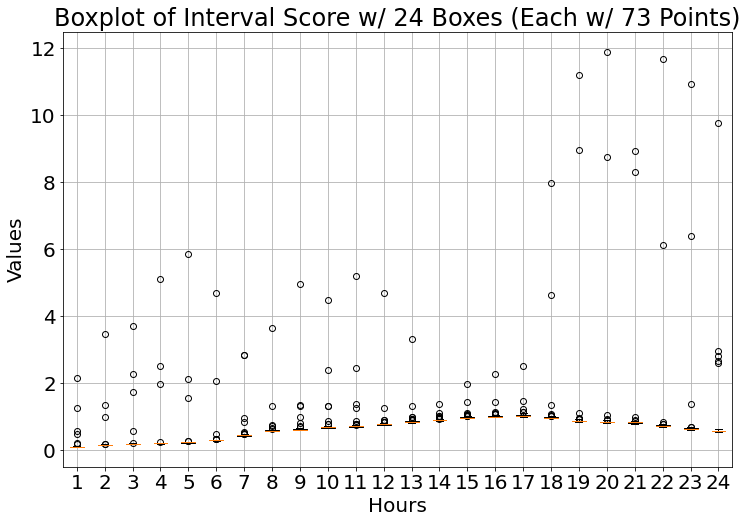

In [21]:
# Create a boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(IS)

# Label the axes
plt.xlabel('Hours')
plt.ylabel('Values')
plt.title('Boxplot of Interval Score w/ 24 Boxes (Each w/ 73 Points)')

# Show the plot
plt.grid(True)
plt.show()

#### MAPE

In [22]:
m = np.mean(true_data_test_cond_o, axis=1)
s = np.std(true_data_test_cond_o, axis=1)

median_pred_data_calibrated = (L_star + U_star)/2
median_pred_data_calibrated_o = median_pred_data_calibrated*s[:,np.newaxis] + m[:,np.newaxis]
# Explain np.newaxis:
# Add a new axis to A to convert it from shape (73,) to (73,1),
# so it can broadcast properly with B (shape (73,24)) for row-wise addition

print(f'MSE: {round(np.mean(np.square(true_data_test_target - median_pred_data_calibrated))*1,4)}')
print(f'MAPE: {round(np.mean(abs((true_data_test_target_o - median_pred_data_calibrated_o))/true_data_test_target_o)*100,4)}')


MSE: 0.0257
MAPE: 1.6299


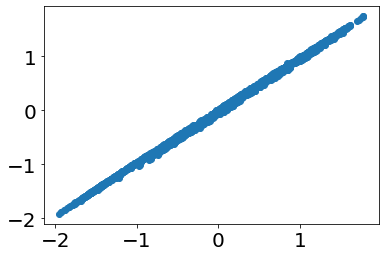

In [23]:
flattened_array1 = median_pred_data_calibrated.flatten()
flattened_array2 = median_pred_data_test.flatten()

# 绘制散点图
plt.scatter(flattened_array1, flattened_array2)
plt.show()

### Compare predictions

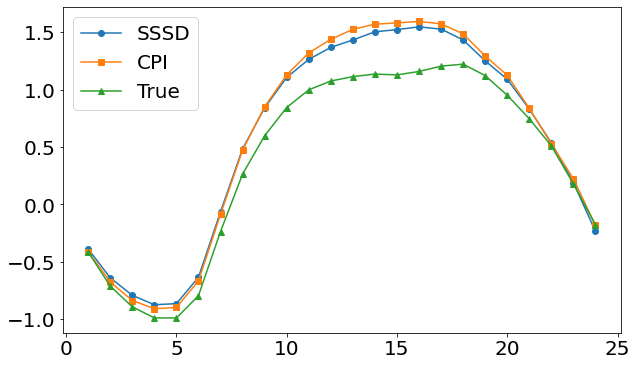

In [24]:
for obs in range(1):

    data1 = median_pred_data_test[obs,:].flatten()
    data2 = median_pred_data_calibrated[obs,:].flatten()
    data3 = true_data_test_target[obs,:].flatten()
    x = np.arange(1, 25)

    plt.figure(figsize=(10, 6))
    plt.plot(x, data1, label='SSSD', marker='o')
    plt.plot(x, data2, label='CPI', marker='s')
    plt.plot(x, data3, label='True', marker='^')
    plt.legend()

## 3: SCP
Split conformal prediction

### Method

In [25]:
true = true_I2
pred = median_pred_I2

# conformity score
E_star_exd = compute_E_star_SCP(pred = pred, true = true, alpha = 0.05)

# calibration data
# L = pred - E_star_exd
# U = pred + E_star_exd

# I2_CR_adjust = coverage_rate(L, U, true_I2)
# CR_barchart_compare(I2_CR_original[0], I2_CR_adjust[0])

# test data
pred = median_pred_test
true = true_test

L = pred - E_star_exd
U = pred + E_star_exd

### Results

#### Coverage rate

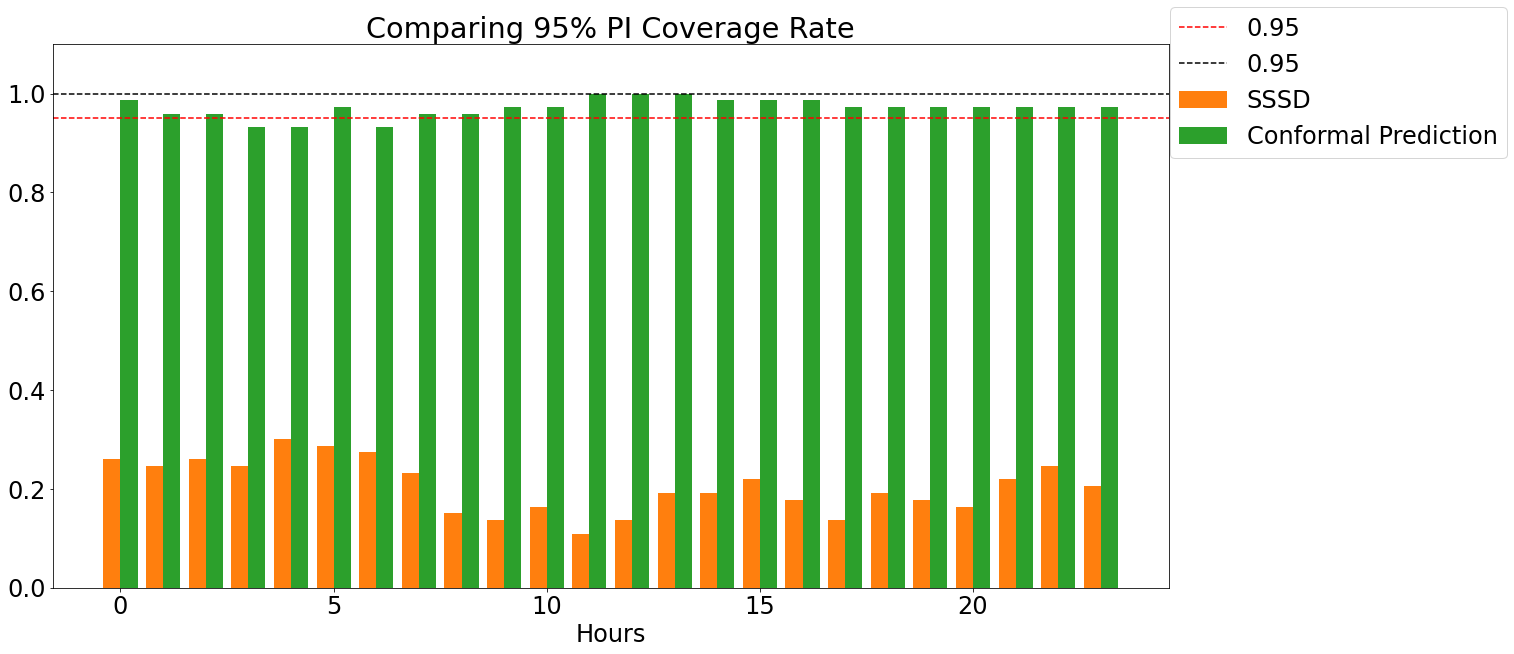

In [26]:


test_CR_SCP = coverage_rate(L, U, true)
CR_barchart_compare(test_CR_original, test_CR_SCP, 
                    figure_title = "Comparing 95% PI Coverage Rate",
                    label_1 = 'SSSD', label_2 = 'Conformal Prediction',
                    color_1 = 'tab:orange', color_2 = 'tab:green')

#### Interval score

In [33]:
IS = Interval_Score(L,U,true,0.05)
np.round(np.mean(IS, axis=0),2)

array([0.16, 0.29, 0.35, 0.37, 0.4 , 0.44, 0.65, 0.82, 0.84, 0.82, 0.85,
       0.91, 1.  , 1.02, 1.04, 1.08, 1.13, 1.22, 1.22, 1.2 , 1.11, 1.  ,
       0.9 , 0.77])

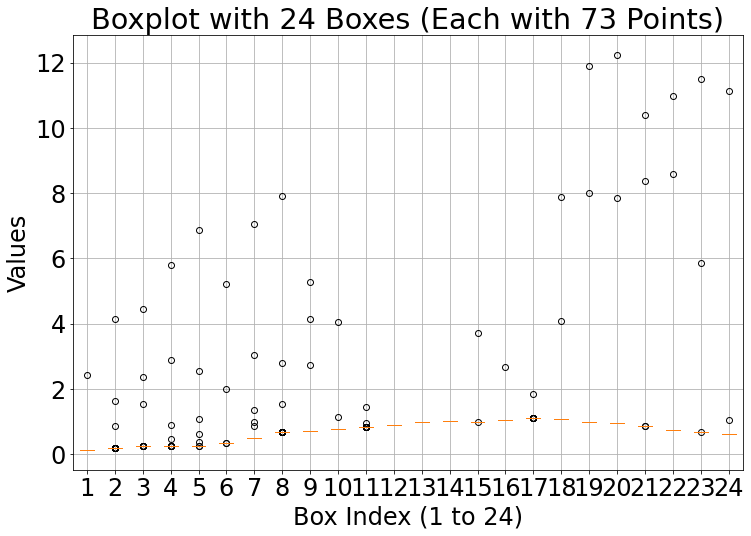

In [34]:
# Create a boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(IS)

# Label the axes
plt.xlabel('Box Index (1 to 24)')
plt.ylabel('Values')
plt.title('Boxplot with 24 Boxes (Each with 73 Points)')

# Show the plot
plt.grid(True)
plt.show()

# Comparison

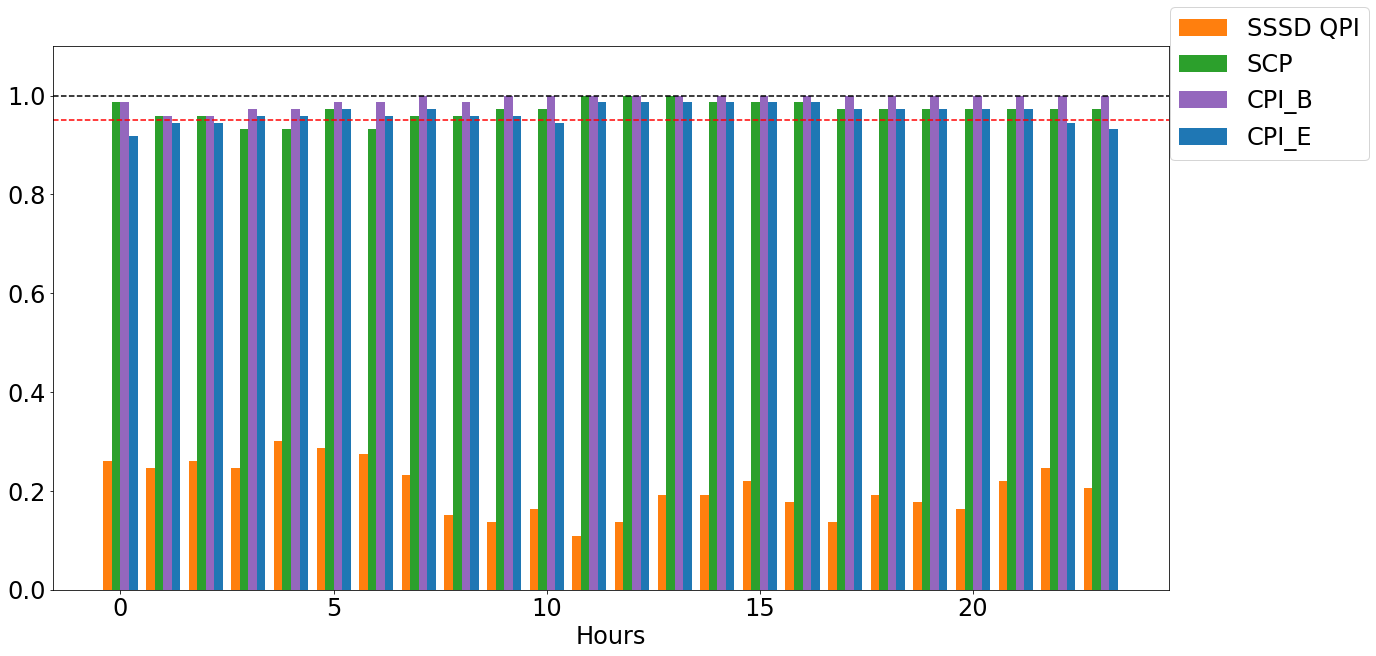

In [ ]:
original_values = test_CR_adjust_1
adjusted_values1 = test_CR_adjust_1
adjusted_values2 = test_CR_adjust_2
adjusted_values3 = test_CR_SCP
figure_title = "Comparing 95% PI Coverage Rate"
label_1 = 'CPI_B'
label_2 = 'CPI_E'
label_3 = 'SCP'
color_1 = 'tab:purple'
color_2 = 'tab:blue'
color_3 = 'tab:green'

X_axis = np.arange(len(original_values)) 


plt.figure(figsize=(20, 10)) 
plt.rcParams['font.size'] = 24 # 設置繪圖時的字體大小

plt.bar(X_axis - 0.3, test_CR_original, 0.2, label = 'SSSD EQPI', color = 'tab:orange') 
plt.bar(X_axis - 0.1, adjusted_values3, 0.2, label = label_3, color = color_3) 
plt.bar(X_axis + 0.1, adjusted_values1, 0.2, label = label_1, color = color_1) 
plt.bar(X_axis + 0.3, adjusted_values2, 0.2, label = label_2, color = color_2) 

# plt.bar(X_axis + 0.1, original_values, 0.2, label = label_1, color = color_1) 



# for i in X_axis:
    # plt.text(X_axis[i] - 0.2, original_values[i] + 0.02, str(round(original_values[i],2)), ha='center', va='bottom')
    # plt.text(X_axis[i] + 0.2, adjusted_values2[i] + 0.03, str(round(adjusted_values2[i],2)), ha='center', va='bottom')

plt.axhline(y=0.95, color='r', linestyle='--')
plt.axhline(y=1, color='black', linestyle='--')


plt.ylim(0, 1.1)
plt.xlabel("Hours") 
plt.ylabel("") 
# plt.title(figure_title) 
# plt.legend(loc = 'upper right', bbox_to_anchor=(1, 0.5)) 
plt.legend(loc=(1.001, 0.79))
plt.show() 

# Clustering

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import skfda
from skfda import datasets
from skfda.exploratory.visualization.clustering import (
    ClusterMembershipLinesPlot,
    ClusterMembershipPlot,
    ClusterPlot,
)
from skfda.ml.clustering import FuzzyCMeans, KMeans

## 分群

In [47]:
I2_winter_index = train_days_I2>0 # >= 10/20


true_data_I2_all_o = true_data_I2_all_o[I2_winter_index,:]
true_data_I2_cond_o = true_data_I2_cond_o[I2_winter_index,:]
true_data_I2_target_o = true_data_I2_target_o[I2_winter_index,:]

print(f"true_data_I2_all_o, shape: {true_data_I2_all_o.shape}")
print(f"true_data_I2_cond_o, shape: {true_data_I2_cond_o.shape}")
print(f"true_data_I2_target_o, shape: {true_data_I2_target_o.shape}")

# I2 dataset
true_data_I2_target = true_data_I2_target[I2_winter_index,:]
mul_pred_data_I2 = mul_pred_data_I2[:,I2_winter_index,:]
median_pred_data_I2 = median_pred_data_I2[I2_winter_index,:]
print(f"true_data_I2_target, shape: {true_data_I2_target.shape}")
print(f"mul_pred_data_I2, shape: {mul_pred_data_I2.shape}")
print(f"median_pred_data_I2, shape: {median_pred_data_I2.shape}")

# pred I2 data back to original scale
mul_pred_data_I2_o = mul_pred_data_I2_o[:,I2_winter_index,:]
median_pred_data_I2_o = median_pred_data_I2_o[I2_winter_index,:]
print(f"mul_pred_data_I2_o, shape: {mul_pred_data_I2_o.shape}")
print(f"median_pred_data_I2_o, shape: {median_pred_data_I2_o.shape}")
true_data_I2_cond = true_data_I2_cond[I2_winter_index,:]
true_data_I2_all = true_data_I2_all[I2_winter_index,:]
print(f"true_data_I2_cond, shape: {true_data_I2_cond.shape}")
print(f"true_data_I2_all, shape: {true_data_I2_all.shape}")


true_data_I2_all_o, shape: (2061, 192)
true_data_I2_cond_o, shape: (2061, 168)
true_data_I2_target_o, shape: (2061, 24)
true_data_I2_target, shape: (2061, 24)
mul_pred_data_I2, shape: (50, 2061, 24)
median_pred_data_I2, shape: (2061, 24)
mul_pred_data_I2_o, shape: (50, 2061, 24)
median_pred_data_I2_o, shape: (2061, 24)
true_data_I2_cond, shape: (2061, 168)
true_data_I2_all, shape: (2061, 192)


In [50]:
true_data_I2_cond.shape

(2061, 168)

In [51]:
num_cluster = 12

# // apply clustering on the previous 7 days
# data_pre = np.squeeze(true_data_I2_cond, axis = 1)
data_pre = true_data_I2_cond

grid_points = range(data_pre.shape[1])

fd = skfda.FDataGrid(data_pre, grid_points)
model = skfda.ml.clustering.KMeans(n_clusters=num_cluster, random_state=0)
model.fit(fd)
group_center = model.cluster_centers_.data_matrix # (n_clusters, # of length, ?)
group_fd = model.predict(fd)
count_group = np.bincount(group_fd, minlength=num_cluster) 


In [52]:
count_group

array([214,  54, 230,  91, 245, 231,  93, 239, 238,  98, 247,  81])

In [53]:
true_data_I2_all.shape

(2061, 192)

## 分群結果 plot

(2061, 192)


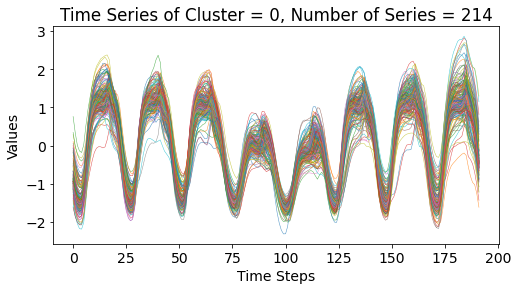

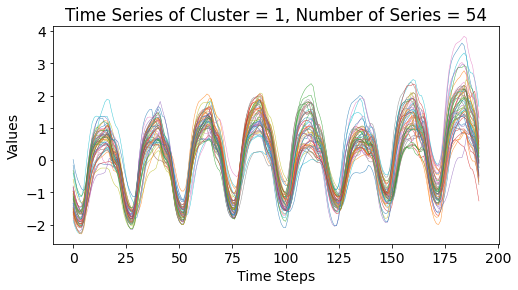

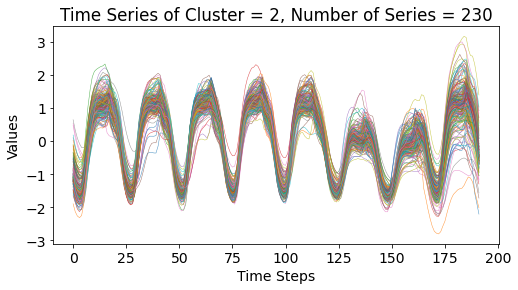

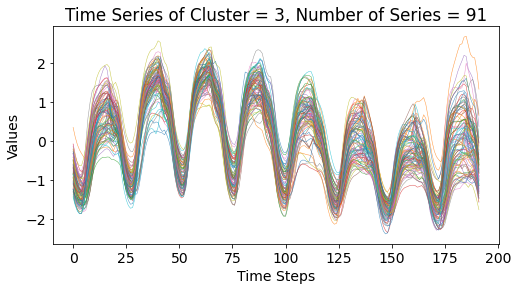

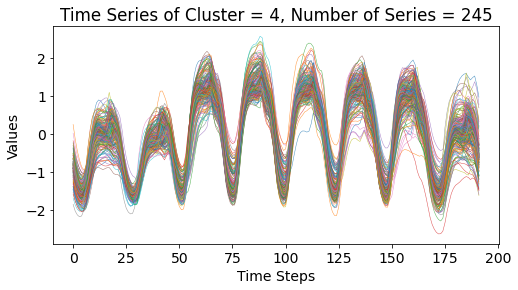

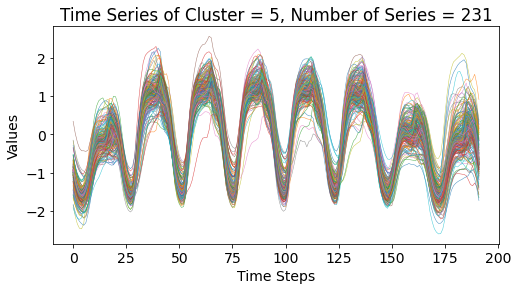

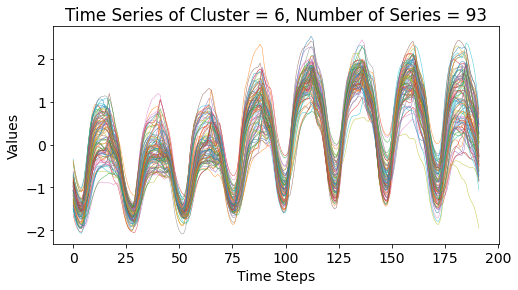

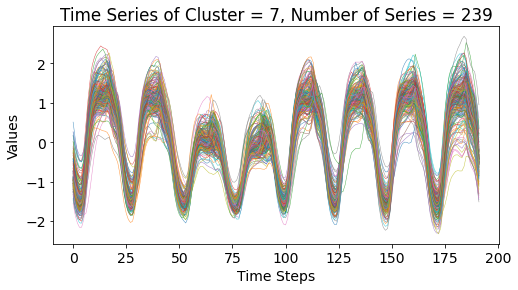

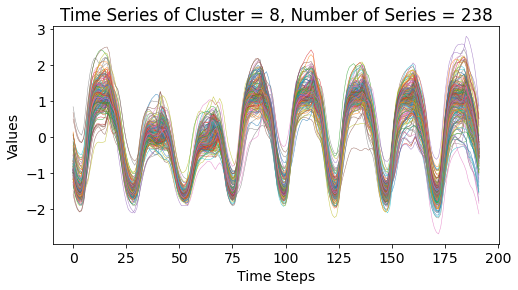

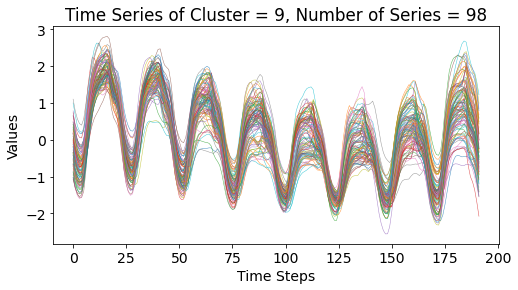

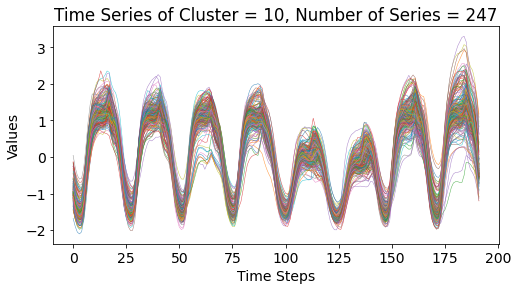

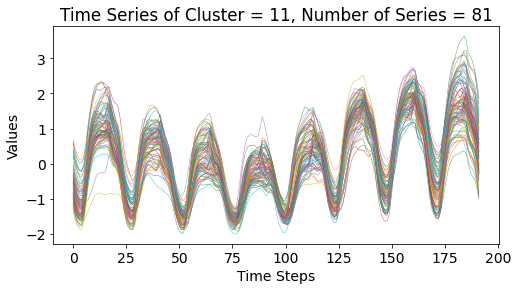

In [55]:
# d = np.squeeze(true_data_I2_all, axis = 1)
d = true_data_I2_all
print(d.shape)

for i in range(num_cluster):
    # 創建一個圖形和軸對象
    plt.figure(figsize=(8, 4))
    # 設置繪圖時的字體大小
    plt.rcParams['font.size'] = 14
    # 繪製每條時間序列
    for series in d[group_fd==i,:]:
        plt.plot(series, linewidth=0.5, alpha=0.8)  # alpha用於設置透明度，以便更好地視覺化重疊

    # 設置標題和軸標籤
    plt.title(f'Time Series of Cluster = {i}, Number of Series = {count_group[i]}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    # plt.ylim(-3.5,4)

    # 顯示圖表
    plt.show()

## Compute E*

### Method 1

In [164]:
# L, U = pred_interval(mul_pred_data_I2, beta = 0.05)
# E_star_all = compute_E_star(L, U, true_data_I2, alpha = 0.05)

# E_star_ls = []
# for i in range(num_cluster):
#     # print(i)
#     pred_data = mul_pred_data_I2[:,group_fd==i,:,:]
#     true_data = true_data_I2[group_fd==i,:,:]

#     L, U = pred_interval(pred_data, beta = 0.05)
#     E_star_ls.append(compute_E_star(L, U, true_data, alpha = 0.05))

# E_star_group = np.vstack(E_star_ls)

### Method 2

In [165]:
# L, U = pred_interval(mul_pred_data_I2, beta = 0.05)
# E_star_all_L, E_star_all_U = compute_E_star_separate(L, U, true_data_I2_target, alpha = 0.05)

E_star_ls_L = []; E_star_ls_U = []
for i in range(num_cluster):

    pred_data = mul_pred_data_I2[:,group_fd==i,:,:]
    true_data = true_data_I2_target[group_fd==i,:,:]

    L, U = pred_interval(pred_data, beta = 0.05)

    E_star_L, E_star_U = compute_E_star_separate(L, U, true_data, alpha = 0.025)
    E_star_ls_L.append(E_star_L)
    E_star_ls_U.append(E_star_U)

E_star_group_L = np.vstack(E_star_ls_L)
E_star_group_U = np.vstack(E_star_ls_U)

## 測試資料分群

In [166]:
# // apply clustering on the previous 7 days
data_pre = np.squeeze(true_data_test_cond, axis = 1)

# // apply clustering on the predictions
# data = np.squeeze(pred_mean_test, axis = 1)
# data_pre = data[:,-24:] 

# // apply clustering on the previous 7 days + the predictions
# data1 = np.squeeze(true_data_test_all, axis = 1)
# data2 = np.squeeze(pred_mean_test, axis = 1)
# data_pre = np.concatenate((data1[:,0:-24], data2[:,-24:]), axis=1)

grid_points = range(data_pre.shape[1])

fd = skfda.FDataGrid(data_pre, grid_points)
group_fd = model.predict(fd) 
count_group = np.bincount(group_fd, minlength=num_cluster)  # minlength 确保数组长度至少为num_cluster，即使某些数字没有出现
count_group

array([18,  8,  9,  5, 11, 10, 12])

## Adjust PI for each group

### Method 1

In [167]:
# true_data_ls = []
# L_ls = []
# U_ls = []
# L_star_ls = []
# U_star_ls = []

# for i in range(num_cluster):
#     pred_data = mul_pred_data_test[:,group_fd==i,:,:]
#     true_data = true_data_test_target[group_fd==i,:,:]

#     L, U = pred_interval(pred_data, beta = 0.05)
#     L_star, U_star = adjust_PI(L, U, E_star_ls[i])

#     true_data_ls.append(true_data)
#     L_ls.append(L)
#     U_ls.append(U)
#     L_star_ls.append(L_star)
#     U_star_ls.append(U_star)



# test_CR_original = coverage_rate(np.vstack(L_ls), np.vstack(U_ls), np.vstack(true_data_ls))
# test_CR_adjust = coverage_rate(np.vstack(L_star_ls), np.vstack(U_star_ls), np.vstack(true_data_ls))

# CR_barchart_compare(test_CR_original[0], test_CR_adjust[0], 
#                     figure_title = f'Comparing Prediction Interval Coverage: Original vs. Adjusted (Clusters = {num_cluster})')


### Method 2

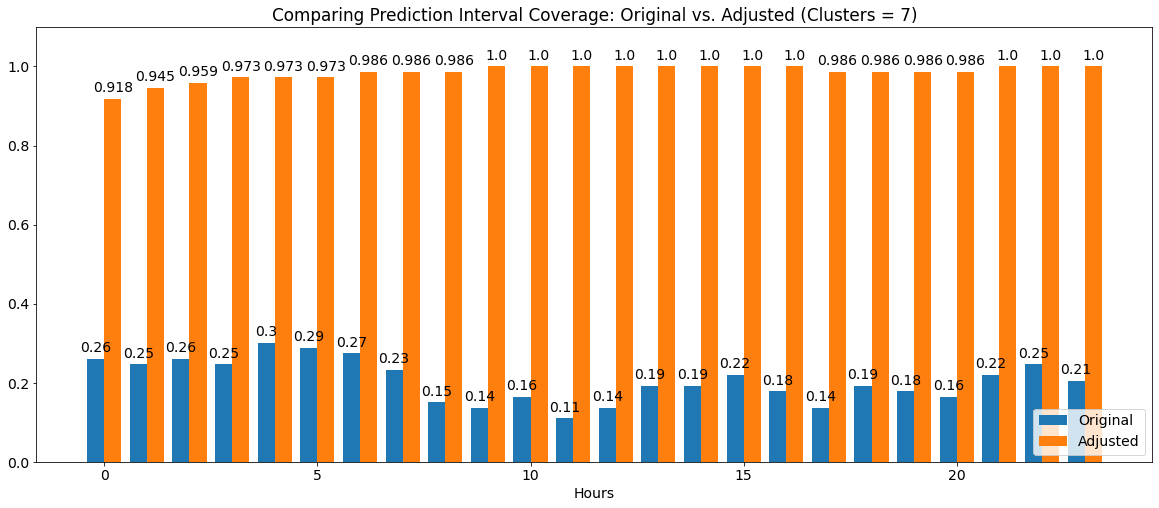

In [168]:
true_data_ls = []
L_ls = []
U_ls = []
L_star_ls = []
U_star_ls = []

pred_mean_calibrated = np.zeros(true_data_test_target.shape)

for i in range(num_cluster):
    pred_data = mul_pred_data_test[:,group_fd==i,:,:]
    true_data = true_data_test_target[group_fd==i,:,:]

    L, U = pred_interval(pred_data, beta = 0.05)
    L_star, U_star = adjust_PI_separate(L, U, E_star_ls_L[i], E_star_ls_U[i])


    true_data_ls.append(true_data)
    L_ls.append(L)
    U_ls.append(U)
    L_star_ls.append(L_star)
    U_star_ls.append(U_star)

    pred_mean_calibrated[group_fd==i,:,:] = (L_star + U_star)/2 # L_star & U_star are from Method 2



test_CR_original = coverage_rate(np.vstack(L_ls), np.vstack(U_ls), np.vstack(true_data_ls))
test_CR_adjust = coverage_rate(np.vstack(L_star_ls), np.vstack(U_star_ls), np.vstack(true_data_ls))

CR_barchart_compare(test_CR_original[0], test_CR_adjust[0], 
                    figure_title = f'Comparing Prediction Interval Coverage: Original vs. Adjusted (Clusters = {num_cluster})')


## method 2 的 MAPE

In [169]:
# print(f'MAPE: {round(np.mean(abs((true_data_test_target_o - pred_mean_calibrated))/true_data_test_target_o)*100,4)}')


m = np.mean(true_data_test_cond_o, axis=2).reshape((true_data_test_target_o.shape[0], true_data_test_target_o.shape[1], 1))
s = np.std(true_data_test_cond_o, axis=2).reshape((true_data_test_target_o.shape[0], true_data_test_target_o.shape[1], 1))

pred_mean_calibrated_o = pred_mean_calibrated*s + m

print(f'MSE: {round(np.mean(np.square(true_data_test_target - pred_mean_calibrated))*1,4)}')
print(f'MAPE: {round(np.mean(abs((true_data_test_target_o - pred_mean_calibrated_o))/true_data_test_target_o)*100,4)}')


MSE: 0.0291
MAPE: 1.7802


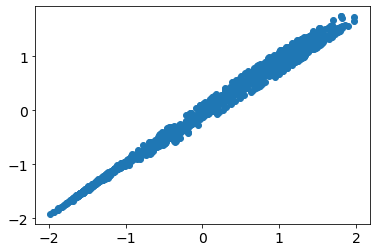

In [170]:
flattened_array1 = pred_mean_calibrated.flatten()
flattened_array2 = median_pred_data_test.flatten()

# 绘制散点图
plt.scatter(flattened_array1, flattened_array2)
plt.show()

## 比較分群後 E* 結果

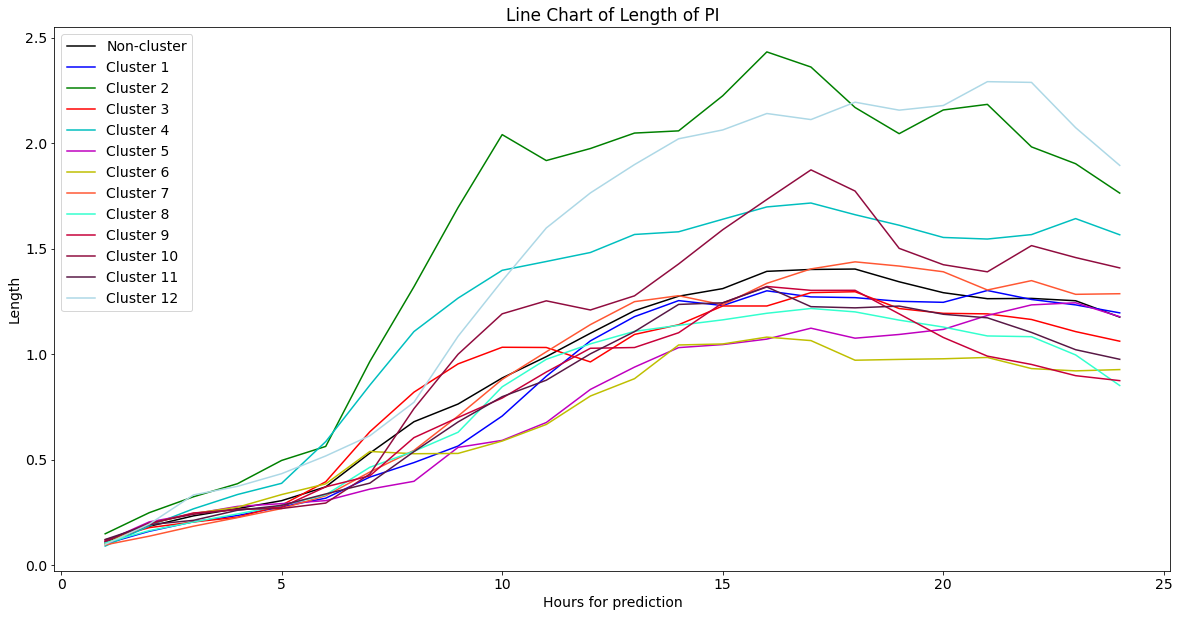

In [234]:
# 資料
data = np.vstack([E_star_all, E_star_group])
data = 2*data # length of PI

# 設定 x 軸的數據點
x_points = np.arange(1, 25)  # 生成一個從1到24的數組

# 定義顏色列表，這裡列出了 20 種不同的顏色，你可以根據需要更改
colors = [
    'k', 'b', 'g', 'r', 'c', 'm', 'y',  # 基本顏色
    '#FF5733', '#33FFCE', '#C70039', '#900C3F', '#581845',  # HEX code顏色
    'lightblue', 'lightgreen', 'crimson', 'orange', 'purple', 'brown', 'pink', 'gray'
]

# 設置繪圖時的字體大小
plt.rcParams['font.size'] = 14
# 創建圖表
plt.figure(figsize=(20, 10))

# 繪製每條線
for i in range(data.shape[0]):
    if i == 0:
        plt.plot(x_points, data[i], label=f'Non-cluster', color=colors[i % len(colors)]) 
    else:
        plt.plot(x_points, data[i], label=f'Cluster {i}', color=colors[i % len(colors)]) 


# 添加圖例
plt.legend(loc = 'upper left')

# 添加標題和軸標籤
plt.title('Line Chart of Length of PI')
plt.xlabel('Hours for prediction')
plt.ylabel('Length')

# 顯示圖表
plt.show()


In [235]:
# compare E_star_all and E_star_group
print(f'未分群 E_star {E_star_all.shape}')
print(f'分群後 E_star {E_star_group.shape}')


未分群 E_star (1, 24)
分群後 E_star (12, 24)


In [237]:
E_star_smaller = E_star_group < E_star_all
print(f'每一組有幾個時間點 E_star 變小: {np.sum(E_star_smaller, axis = 1)}')
print(f'24個時間點中，有幾組的 E_star 變小:{np.sum(E_star_smaller, axis = 0)}')
print(f'{73*24} 個時間點中，有 {np.sum(count_group * np.sum(E_star_smaller, axis = 1))} 個 E* 變小')

每一組有幾個時間點 E_star 變小: [22  0 17  1 19 18 12 24 20  4 22  1]
24個時間點中，有幾組的 E_star 變小:[6 4 5 7 8 6 7 7 7 7 6 7 7 7 8 8 7 7 7 7 6 7 7 5]
1752 個時間點中，有 1312 個 E* 變小


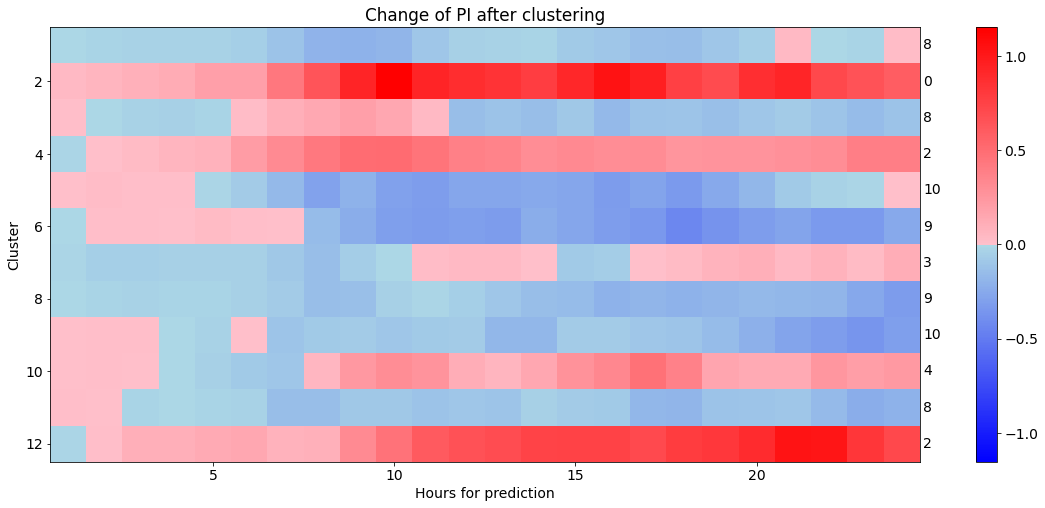

In [238]:
# Change of PI after clustering
E_star_diff = E_star_group - E_star_all

from matplotlib.colors import LinearSegmentedColormap
data = 2*E_star_diff
# 创建自定义颜色映射
# colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]  # (value, color) pairs
colors = [(0, 'blue'), (0.499, 'lightblue'), (0.501, 'pink'),  (1, 'red')]  # (value, color) pairs
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
# 設置繪圖時的字體大小
plt.rcParams['font.size'] = 14

# 创建热力图
fig, ax = plt.subplots(figsize=(20, 8))
cax = ax.imshow(data, cmap=cmap, interpolation='nearest', extent=[0.5, 24.5, 12.5, 0.5], vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
# 设置vmin和vmax来确保颜色映射正确显示
plt.colorbar(cax)  # 添加颜色条
ax.set_title('Change of PI after clustering')
ax.set_xlabel('Hours for prediction')
ax.set_ylabel('Cluster')
# 添加右側的數字標記
hours_labels = count_group  # 假設每個Cluster對應一個小時數
for i, label in enumerate(hours_labels):
    ax.text(24.6, i + 1, str(label), va='center', ha='left')

plt.show()

## 測試資料分群結果 plot

In [99]:
# d = np.squeeze(true_data_test_all, axis = 1)
# print(d.shape)

# for i in range(num_cluster):
#     # 創建一個圖形和軸對象
#     plt.figure(figsize=(8, 4))
#     # 設置繪圖時的字體大小
#     plt.rcParams['font.size'] = 14
#     # 繪製每條時間序列
#     for series in d[group_fd==i,:]:
#         plt.plot(series, linewidth=0.5, alpha=0.8)  # alpha用於設置透明度，以便更好地視覺化重疊

#     # 設置標題和軸標籤
#     plt.title(f'Time Series of Cluster = {i}, Number of Series = {count_group[i]}')
#     plt.xlabel('Time Steps')
#     plt.ylabel('Values')

#     # 顯示圖表
#     plt.show()

## 哪些 PI 沒有包含 test data

In [38]:
test_CR_adjust = coverage_rate(np.vstack(L_star_ls), np.vstack(U_star_ls), np.vstack(true_data_ls))
test_CR_adjust

array([[0.98630137, 0.97260274, 0.94520548, 0.95890411, 0.97260274,
        0.98630137, 0.95890411, 0.97260274, 0.97260274, 0.98630137,
        0.98630137, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.97260274, 0.97260274,
        0.98630137, 0.98630137, 0.98630137, 0.98630137]])

In [45]:
# 找出 73 中哪些沒有被 PI 包含

# 創造 (73,192,1) test data into group
print(data.shape)
for i in range(num_cluster):
    data_ls = data[group_fd==i,:,:]

# convert list to array
L_star_group = np.vstack(L_star_ls)
U_star_group = np.vstack(U_star_ls)
true_data_group = np.vstack(true_data_ls)
data_group = np.vstack(data_ls)



In [ ]:
# 0-read file
df_all_time = pd.read_pickle('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/df_all_time.pkl')

# 1-the day of the year
date_range = pd.date_range(start='2005-01-31', end='2016-10-19')
days = date_range.to_series().dt.dayofyear # 創建一個 Series，包含每個日期是一年當中第幾天
train_all_days = days[7:]
print(train_all_days.shape)


# 2-training data (在切割training and test data時會drop有nan的series，所以需要知道其 index)
df = df_all_time
train_start = '2005-01-31 00:00:00'
train_end = '2016-10-19 23:00:00'
test_start = '2016-10-13 00:00:00'
test_end = '2016-12-31 23:00:00'
zone_number = 1
days_window = 8
zone_name = 'N.Y.C.'

if zone_name == 'ALL':
    df_train = df[(df['Date']>=train_start) 
                & (df['Date']<=train_end)] 
    df_test  = df[(df['Date']>=test_start) 
                & (df['Date']<=test_end)]
else:
    df_train = df[(df['Zone']==zone_name) 
                & (df['Date']>=train_start) 
                & (df['Date']<=train_end)] 
    df_test  = df[(df['Zone']==zone_name) 
                & (df['Date']>=test_start)
                & (df['Date']<=test_end)]
    
np_train, day_of_week_train = pd_to_numpy(df_train, zone_number, days_window) # np_train.shape = 4273
# remove rows (reduce obs.) which contain nan,  (obs., channel, length)
load_array_train = np_train[~np.isnan(np_train).any(axis=(1,2))] 
# exchange channel and length (obs., 1, length) -> (obs., length, 1) 
load_array_train = np.einsum('ijk->ikj',load_array_train)


# 3-根據train沒有因為na被drop的index選取days
train_days = train_all_days[~np.isnan(np_train).any(axis=(1,2))] 
print(train_days.shape)


# 4-根據I1和I2 index切分 dyas
data_npy = load_array_train
np.random.seed(42)

random_indices = np.random.choice(data_npy.shape[0], data_npy.shape[0]//2, replace=False)
remaining_indices = np.setdiff1d(np.arange(data_npy.shape[0]), random_indices)

sample_I1 = data_npy[random_indices]
sample_I2 = data_npy[remaining_indices]

train_days_I1 = train_days.iloc[random_indices]
train_days_I2 = train_days.iloc[remaining_indices]
print(np.sum(train_days_I1>294))
print(np.sum(train_days_I2>294))

(4273,)
(4121,)
364
411
